In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import glob

import sys
sys.path.append("../..") # include base dir

from jlonevae_lib.architecture.load_model import load_model
import jlonevae_lib.architecture.vae_jacobian as vj

In [2]:
### COPYPASTA from disentanglement_lib/disentanglement_lib/data/ground_truth/threeDots.py
### EASIER than trying to figure out how to import that file here

# create an image with dots of the given radius (range 0 to 1)
# placed at the given locations (shape: (N, 2)) in the range 0 to 1
# the output image is shape (64, 64, 1)
# with a black dot on a white background
# and some gray colors on the border pixels
# (the gray color is created by making a purely black circle on a 10x larger image
# and then resizing the image smaller and averaging nearby pixels
def draw_dots_to_image_array(radius, dot_centers):
    num_object = dot_centers.shape[0]
    im_side_len = 64
    # in order to get nicely averaged/grayscale shape boundary
    # we draw on a larger canvas and scale down
    # Create a black image
    upscale_image_factor = 10
    precision_scale = 10
    black = 0 
    up_img = np.ones((im_side_len * upscale_image_factor,im_side_len *
      upscale_image_factor,1))
    up_radius = int(im_side_len * radius * upscale_image_factor * 2**precision_scale)
    for i in range(num_object):
        up_center = np.floor(im_side_len * dot_centers[i] * upscale_image_factor * 2**precision_scale).astype(int)
        # negative thickness means filled circle
        circle = cv2.circle(up_img, tuple(up_center), up_radius, color=black, thickness = -1, shift=precision_scale)
    arr = cv2.resize(up_img, (im_side_len,im_side_len), interpolation=cv2.INTER_AREA)
    return arr

# Embed into model

In [3]:
combinedOutputs = "threeDotRepeatedSeeds/trainedModels"

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
def get_model_and_enc(gammastring, timestamp):
    base_locs = np.array([[32/64., 16/64.],[48/64,32/64.],[16/64.,48/64.]])
    test_data = np.array([[draw_dots_to_image_array(0.08, base_locs)]])
    matching_model_paths = glob.glob(f"../../{combinedOutputs}/defaultConv_lone_beta4_0000_ica{gammastring}_lat10_batch64_lr0_0001_anneal100000/{timestamp}/representation/cache_batch_no300000")
    print("using model %s" % matching_model_paths)
    model_path = matching_model_paths[0]

    model = load_model(model_path,device).double();
    encoding, logvar = model.encode(torch.tensor(test_data).double().to(device));
    return model, encoding

# Find the most active columns and plot them 

In [5]:
# contrast adjustment for jacobian
scale = 20
outputdir = "./threeDotsJacobians/"
from pathlib import Path
Path.mkdir(Path(outputdir), exist_ok=True)

0_1000
0_1000
0_1000
0_1000
using model ['../../threeDotRepeatedSeeds/trainedModels/defaultConv_lone_beta4_0000_ica0_1000_lat10_batch64_lr0_0001_anneal100000/20210525-080220/representation/cache_batch_no300000']
(64, 64)


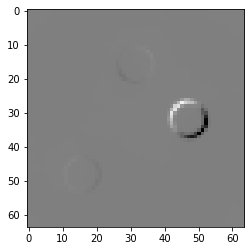

(64, 64)


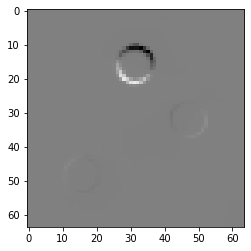

(64, 64)


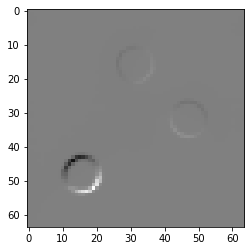

(64, 64)


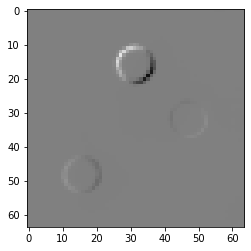

(64, 64)


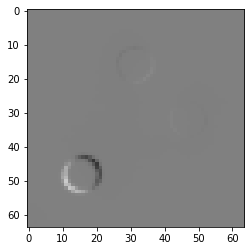

(64, 64)


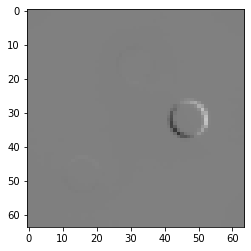

(64, 64)


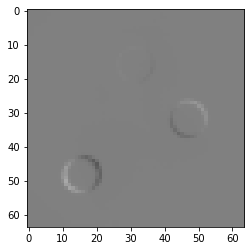

(64, 64)


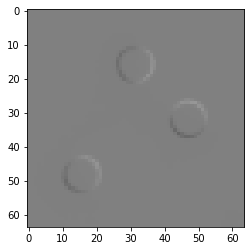

(64, 64)


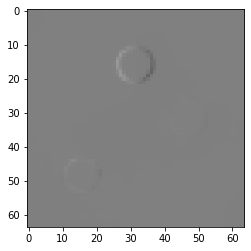

(64, 64)


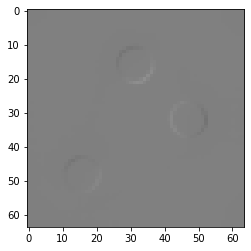

0_0000
0_0000
0_0000
0_0000
using model ['../../threeDotRepeatedSeeds/trainedModels/defaultConv_lone_beta4_0000_ica0_0000_lat10_batch64_lr0_0001_anneal100000/20210525-071950/representation/cache_batch_no300000']
(64, 64)


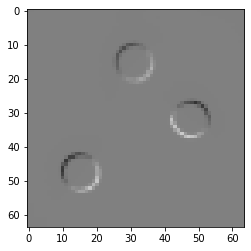

(64, 64)


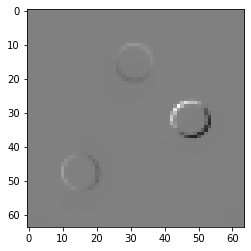

(64, 64)


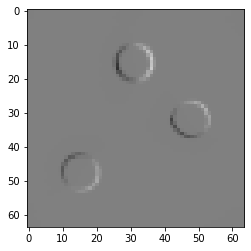

(64, 64)


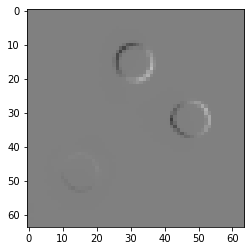

(64, 64)


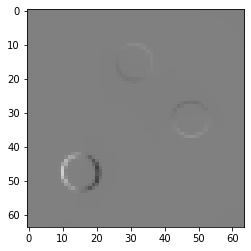

(64, 64)


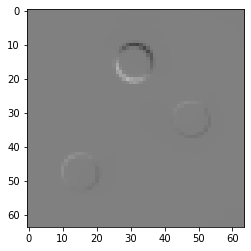

(64, 64)


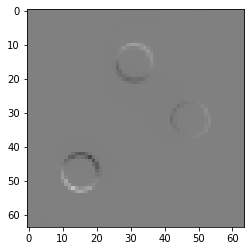

(64, 64)


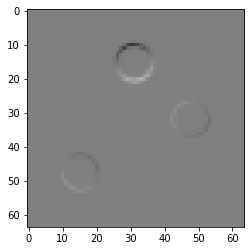

(64, 64)


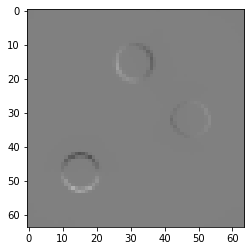

(64, 64)


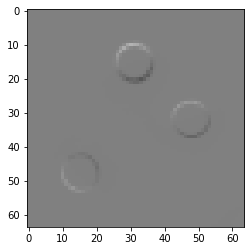

In [6]:
# either switch these timestamps to * (to find any matchign run)
# or update to a particular run. These timestamps are associated with the models used in the paper
for gammastring, timestamp in [("0_1000","20210525-080220"),("0_0000","20210525-071950")]:
    print(gammastring)
    print(gammastring)
    print(gammastring)
    print(gammastring)
    model, encoding = get_model_and_enc(gammastring,timestamp)
    jacs = vj.compute_generator_jacobian_analytic(model, encoding, device=device,
                                        im_channels=1)#.detach().cpu().numpy()
    activities = [np.sum(np.square(jac)) for jac in jacs]
    top_jac_inds = np.flip(np.argsort(activities))
    for q, ind in enumerate(top_jac_inds):
        print(jacs[ind].squeeze().shape)
        added_constrast_jac = jacs[ind,0].transpose(1,2,0) * scale + 255/2.
        plt.imshow(added_constrast_jac[:,:,0], vmin=0, vmax=255, cmap="gray");plt.show();plt.close();
        cv2.imwrite(outputdir+"ThreeDotsJacGamma%sLatent%dModel%s.png" %(gammastring,q, timestamp), added_constrast_jac);